In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from bagpy import bagreader

# import data from recording at Klitten FVZ
results_file = "./Klitten/loc_results_2023-11-01-12-53-52_0.bag"
sensor_file = "./Klitten/recordedData_sensors_locpc_2023-11-01-12-53-52_0.bag"

result_reader = bagreader(results_file)
sensor_reader = bagreader(sensor_file)


# Thius function extracts the sensordata into CSV-files

map_path = result_reader.message_by_topic(topic="/odometry/filtered/map")
#odom_path = result_reader.message_by_topic(topic="/odometry/filtered/odom")
#gps_odometry_path  = result_reader.message_by_topic(topic="/odometry/gps")
imu_oem = sensor_reader.message_by_topic(topic="/localization_pc/can0/decoded/imu")
#speed_oem = sensor_reader.message_by_topic(topic="/localization_pc/can0/decoded/speed")
#steeringAngle_oem = sensor_reader.message_by_topic(topic="/localization_pc/can0/decoded/steeringAngle")
#gnss_oem = sensor_reader.message_by_topic(topic="/localization_pc/can0/decoded/gnss")
#imu_anavs = sensor_reader.message_by_topic(topic="/localization_pc/sensor/anavs/imu")
#navsat_anavs = sensor_reader.message_by_topic(topic="/localization_pc/sensor/anavs/navsat")


# You can then use Pandas to read the files.
df_map_path = pd.read_csv(map_path)  
#df_odom_path = pd.read_csv(odom_path)  
# df_gps_path = pd.read_csv(gps_odometry_path)
#df_speed = pd.read_csv(speed_oem)
df_imu = pd.read_csv(imu_oem)

# 我写的
# df_imu_anavs = pd.read_csv(imu_anavs)
# df_navsat_anvas = pd.read_csv(navsat_anavs)

[INFO]  Data folder ./Klitten/loc_results_2023-11-01-12-53-52_0 already exists. Not creating.
[INFO]  Data folder ./Klitten/recordedData_sensors_locpc_2023-11-01-12-53-52_0 already exists. Not creating.


#### Die Zeitdaten von `header.stamp.secs` sollen verschoben werden, sodass sie ab 0 Sekunden beginnen.

In [2]:
df_map_path['header.stamp.secs'] = df_map_path['header.stamp.secs'] - df_map_path['header.stamp.secs'].iloc[0]
df_imu['header.stamp.secs'] = df_imu['header.stamp.secs'] - df_imu['header.stamp.secs'].iloc[0]

#### Die Anzeigeformatierung für DataFrame einstellen

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', 20)

#### Eine neue Spalte `secs.nsecs` zwischen `header.stamp.secs` und `header.stamp.nsecs` einfügen, sodass der Zeitstempel in Sekunden mit Dezimalstellen dargestellt wird.

In [4]:
# 计算新列
df_imu['secs.nsecs'] = df_imu['header.stamp.secs'] + df_imu['header.stamp.nsecs'] * 1e-9
df_imu['secs.nsecs'] = df_imu['secs.nsecs'].round(9)
# 调整列的位置，将 'secs.nsecs' 放到 'header.stamp.nsecs' 后面
columns = df_imu.columns.tolist()
index = columns.index('header.stamp.nsecs') + 1  # 获取目标列的索引并加1
columns.insert(index, columns.pop(columns.index('secs.nsecs')))  # 移动 secs.nsecs 列

# 重新排列列顺序
df_imu = df_imu[columns]

In [5]:
# 计算新列
df_map_path['secs.nsecs'] = df_map_path['header.stamp.secs'] + df_map_path['header.stamp.nsecs'] * 1e-9
df_map_path['secs.nsecs'] = df_map_path['secs.nsecs'].round(9)
# 调整列的位置，将 'secs.nsecs' 放到 'header.stamp.nsecs' 后面
columns = df_map_path.columns.tolist()
index = columns.index('header.stamp.nsecs') + 1  # 获取目标列的索引并加1
columns.insert(index, columns.pop(columns.index('secs.nsecs')))  # 移动 secs.nsecs 列

# 重新排列列顺序
df_map_path = df_map_path[columns]

#### Die für die control-input \( u \) erforderlichen Daten aus den Sensordaten extrahieren.

In [6]:
# u, cov_u = func_u(k, dt_step)
import ast
# 定义函数 func_u
def func_u(k, dt_step):
    t = k * dt_step

    # 从 df_map_path 中找到与 t 值最接近的 index
    idx_v               = (df_map_path['secs.nsecs'] - t).abs().idxmin()
    v                   = df_map_path.loc[idx_v, 'twist.twist.linear.x']
    cov_v_str           = df_map_path.loc[idx_v, 'twist.covariance']
    cov_v_parsed_matrix = ast.literal_eval(cov_v_str)
    cov_v_matrix        = np.array(cov_v_parsed_matrix ).reshape(6, 6)
    cov_v               = cov_v_matrix[0, 0]
    
    # 从 df_imu 中找到与 t 值最接近的 index
    idx_omega = (df_imu['secs.nsecs'] - t).abs().idxmin()
    omega     = df_imu.loc[idx_omega, 'angular_velocity.z']
    cov_omega = df_imu.loc[idx_omega, 'angular_velocity_covariance_8']
    
    u = np.array([v, omega])
    cov_u = np.array([cov_v, cov_omega])
    return u, cov_u
    
# k = 200
# dt_step = 0.1
# u, cov_u = func_u(k, dt_step)

#### Die für die Zustansmatrix (X) erforderlichen Daten aus den Sensordaten extrahieren.

In [7]:
# z, cov_z = func_z(k, dt_step)   
import ast
from sympy import symbols, Matrix

# 定义函数 func_z
def func_z(k, dt_step):
    t = k * dt_step

    # 从 df_map_path 中找到与 t 值最接近的 index
    idx                    = (df_map_path['secs.nsecs'] - t).abs().idxmin()
    x                      = df_map_path.loc[idx, 'pose.pose.position.x']
    y                      = df_map_path.loc[idx, 'pose.pose.position.y']
    theta                  = df_map_path.loc[idx, 'pose.pose.orientation.z']
    z                      = Matrix([x, y, theta])
    
    cov_pose_str           = df_map_path.loc[idx, 'pose.covariance']
    cov_pose_parsed_matrix = ast.literal_eval(cov_pose_str)
    cov_x                  = cov_pose_parsed_matrix[0]
    cov_y                  = cov_pose_parsed_matrix[7]
    cov_xy                 = cov_pose_parsed_matrix[1]
    cov_theta              = cov_pose_parsed_matrix[14]
    cov_z                  = np.array([cov_x, cov_y, cov_xy, cov_theta])
    
    # cov_pose_str           = df_map_path.loc[idx, 'pose.covariance']
    # cov_pose_parsed_matrix = ast.literal_eval(cov_pose_str)
    # cov_pose_matrix        = np.array(cov_pose_parsed_matrix).reshape(6, 6)
    # cov_x                  = cov_pose_matrix[0, 0]
    # cov_y                  = cov_pose_matrix[1, 1]
    # cov_xy                 = cov_pose_matrix[1, 0]
    # cov_theta              = cov_pose_matrix[2, 2]
    # cov_z                  = np.array([cov_x, cov_y, cov_xy, cov_theta])

    return z, cov_z
    
# k = 10000
# dt_step = 0.1
# z, cov_z = func_z(k, dt_step)   

## Determine the required measurement dataset

In [8]:
def SensorData(sensor_type):
    """
    Function to retrieve specific columns from the appropriate DataFrame based on input parameters..

    Parameters: One of the following strings - 'x', 'y', 'heading_angle', 'speed', 'yaw_rate'.

    Returns:
        pd.Series: The corresponding column from the appropriate DataFrame.
    """
    # Define the mapping between sensor types and DataFrame columns
    column_mapping = {
        "x":             ("df_map_path", "pose.pose.position.x"),
        "y":             ("df_map_path", "pose.pose.position.y"),
        "heading_angle": ("df_map_path", "pose.pose.orientation.z"),
        "speed":         ("df_map_path", "twist.twist.linear.x"),
        "yaw_rate":      ("df_imu",      "angular_velocity.z"),
    }

    # Check if the input sensor_type is valid
    if sensor_type not in column_mapping:
        raise ValueError(f"Invalid sensor type: {sensor_type}. Must be one of {list(column_mapping.keys())}")

    # Get the DataFrame and column name
    df_name, column_name = column_mapping[sensor_type]

    # Retrieve the DataFrame object dynamically
    df = globals().get(df_name)
    if df is None:
        raise ValueError(f"DataFrame {df_name} is not defined in the current environment.")

    # Return the corresponding column from the appropriate DataFrame
    return df[column_name]

# Example usage:
# result = SensorData("heading_angle")
# print(result)


In [9]:
# result = SensorData("heading_angle")
# result

# 1. Design the State Variables

$$
\mathbf{X} =
\begin{bmatrix}
x \\
y \\
\theta \\
v \\
\omega
\end{bmatrix}
$$

- **[x, y]**: Position of the vehicle  
- **θ\theta**: Heading angle (\(^\circ\))  
- **v**: Speed (\([m/s]\))  
- **ω**: Yaw rate (\([rad/s]\))

# 2. Design the System Model 

## 2.1 System Jacobian Matrix J

In [10]:
"""from sympy import symbols, Matrix, sin, cos, init_printing

# initialize to show in the form of LaTex
init_printing(use_latex="mathjax", fontsize="16pt")

# define the symbles of variables
x, y, theta, v, omega, time = symbols('x y theta v omega T')  

# define the state vector
X = Matrix([x, y, theta])  

# define state transition f(x, u)
f_xu = Matrix([
    x + v/omega * (sin(theta + omega*time) - sin(theta)), 
    y + v/omega * (cos(theta) - cos(theta + omega*time)),  
    theta + omega*time
])

# calculate jacobian matrix J
J = f_xu.jacobian(X)

J"""

'from sympy import symbols, Matrix, sin, cos, init_printing\n\n# initialize to show in the form of LaTex\ninit_printing(use_latex="mathjax", fontsize="16pt")\n\n# define the symbles of variables\nx, y, theta, v, omega, time = symbols(\'x y theta v omega T\')  \n\n# define the state vector\nX = Matrix([x, y, theta])  \n\n# define state transition f(x, u)\nf_xu = Matrix([\n    x + v/omega * (sin(theta + omega*time) - sin(theta)), \n    y + v/omega * (cos(theta) - cos(theta + omega*time)),  \n    theta + omega*time\n])\n\n# calculate jacobian matrix J\nJ = f_xu.jacobian(X)\n\nJ'

In [11]:
# reduce common expressions
# R = symbols('R')
# J = J.subs(v/omega, R)  # 这里暂且放一下，不对公式进行简化
# J

## 2.2 control input Noise M and Jacobian Matrix V 

In [12]:
"""u = Matrix([v, omega])
V = f_xu.jacobian(u)
# V = V.subs(v/omega, "R")
V"""

'u = Matrix([v, omega])\nV = f_xu.jacobian(u)\n# V = V.subs(v/omega, "R")\nV'

# 3. Design the Measurement Model

# Implementation

## Predict

In [13]:
"""f_xu = Matrix([
    x + v * time * cos(theta),
    x + v * time * cos(theta),
    theta
])"""

'f_xu = Matrix([\n    x + v * time * cos(theta),\n    x + v * time * cos(theta),\n    theta\n])'

In [14]:
"""from sympy import symbols, Matrix, sin, cos, init_printing
from numpy import array
x, y, theta, v, omega, time = symbols('x y theta v omega t')
f_xu = Matrix(
            [x + v/omega * (sin(theta + omega*time) - sin(theta)), 
             y + v/omega * (cos(theta) - cos(theta + omega*time)),  
             theta + omega*time])
F_J = f_xu.jacobian(Matrix([x, y, theta]))
V_J = f_xu.jacobian(Matrix([v, omega]))

def F_J_evaluated(X, u, dt):
    subs = {x: float(X[0, 0]), 
            y: float(X[1, 0]), 
            theta: float(X[2, 0]), 
            v: float(u[0]), 
            omega: float(u[1]), 
            time: float(dt)}
    F_J_evaluated = array(F_J.subs(subs)).astype(float)
    return F_J_evaluated

def V_J_evaluated(X, u, dt):
    subs = {x: float(X[0, 0]), 
            y: float(X[1, 0]), 
            theta: float(X[2, 0]), 
            v: float(u[0]), 
            omega: float(u[1]), 
            time: float(dt)}
    V_J_evaluated = array(V_J.subs(subs)).astype(float)
    return V_J_evaluated

def driving(X, u, dt):
    heading_angle = X[2, 0]
    velocity      = u[0]
    yaw_rate      = u[1]
    
    radius        = velocity/yaw_rate  # R = v / ω
    beta          = yaw_rate * dt
    
    dX = np.array([
        [radius * (sin(heading_angle + beta) - sin(heading_angle))],
        [radius * (cos(heading_angle) - cos(heading_angle + beta))],
        [beta]
    ])

    return X + dX

def prerdict(X, P, u, cov_u, dt):
    predict_X = driving(X=X, u=u, dt = dt)
    cov_v = cov_u[0]
    cov_omega = cov_u[1]
    
    F = F_J_evaluated(X, u, dt)
    V = V_J_evaluated(X, u, dt)
    M = array([[cov_v, 0], 
               [0, cov_omega]])
    predict_P = F @ P @ F.T + V @ M @ V.T
    return predict_X, predict_P"""

"from sympy import symbols, Matrix, sin, cos, init_printing\nfrom numpy import array\nx, y, theta, v, omega, time = symbols('x y theta v omega t')\nf_xu = Matrix(\n            [x + v/omega * (sin(theta + omega*time) - sin(theta)), \n             y + v/omega * (cos(theta) - cos(theta + omega*time)),  \n             theta + omega*time])\nF_J = f_xu.jacobian(Matrix([x, y, theta]))\nV_J = f_xu.jacobian(Matrix([v, omega]))\n\ndef F_J_evaluated(X, u, dt):\n    subs = {x: float(X[0, 0]), \n            y: float(X[1, 0]), \n            theta: float(X[2, 0]), \n            v: float(u[0]), \n            omega: float(u[1]), \n            time: float(dt)}\n    F_J_evaluated = array(F_J.subs(subs)).astype(float)\n    return F_J_evaluated\n\ndef V_J_evaluated(X, u, dt):\n    subs = {x: float(X[0, 0]), \n            y: float(X[1, 0]), \n            theta: float(X[2, 0]), \n            v: float(u[0]), \n            omega: float(u[1]), \n            time: float(dt)}\n    V_J_evaluated = array(V_J.subs(s

In [15]:
from sympy import symbols, Matrix, sin, cos, init_printing
from numpy import array
# x, y, theta, v, omega, time = symbols('x y theta v omega t')

"""# Define f_xu with conditional logic for omega
if omega != 0:
    f_xu = Matrix(
                [x + v/omega * (sin(theta + omega*time) - sin(theta)), 
                 y + v/omega * (cos(theta) - cos(theta + omega*time)),  
                 theta + omega*time])
else:
    f_xu = Matrix([
        x + v * time * cos(theta),
        y + v * time * sin(theta),
        theta
    ])

F_J = f_xu.jacobian(Matrix([x, y, theta]))
V_J = f_xu.jacobian(Matrix([v, omega]))"""

def F_J_evaluated(X, u, dt):
    x, y, theta, v, omega, time = symbols('x y theta v omega t')
    subs_FJ = {x: float(X[0, 0]), 
            y: float(X[1, 0]), 
            theta: float(X[2, 0]), 
            v: float(u[0]), 
            omega: float(u[1]), 
            time: float(dt)}
    if subs_FJ[omega] != 0:
        f_xu = Matrix(
            [x + v/omega * (sin(theta + omega*time) - sin(theta)), 
             y + v/omega * (cos(theta) - cos(theta + omega*time)),  
             theta + omega*time])
    else:
        f_xu = Matrix(
            [x + v * time * cos(theta),
             y + v * time * sin(theta),
             theta])
    F_J = f_xu.jacobian(Matrix([x, y, theta])) 
    F_J_evaluated = array(F_J.subs(subs_FJ)).astype(float)
    return F_J_evaluated

def V_J_evaluated(X, u, dt):
    x, y, theta, v, omega, time = symbols('x y theta v omega t')
    subs_VJ = {x: float(X[0, 0]), 
            y: float(X[1, 0]), 
            theta: float(X[2, 0]), 
            v: float(u[0]), 
            omega: float(u[1]), 
            time: float(dt)}
    if subs_VJ[omega] != 0:
        f_xu = Matrix(
            [x + v/omega * (sin(theta + omega*time) - sin(theta)), 
             y + v/omega * (cos(theta) - cos(theta + omega*time)),  
             theta + omega*time])
    else:
        f_xu = Matrix(
            [x + v * time * cos(theta),
             y + v * time * sin(theta),
             theta])
    V_J = f_xu.jacobian(Matrix([v, omega]))
    V_J_evaluated = array(V_J.subs(subs_VJ)).astype(float)
    return V_J_evaluated

def driving(X, u, dt):
    heading_angle = X[2, 0]
    velocity      = u[0]
    yaw_rate      = u[1]
    
    if yaw_rate != 0:
        radius        = velocity/yaw_rate  # R = v / ω
        beta          = yaw_rate * dt
        dX = np.array([
            [radius * (sin(heading_angle + beta) - sin(heading_angle))],
            [radius * (cos(heading_angle) - cos(heading_angle + beta))],
            [beta]
        ])
    else:
        dX = np.array([
            [velocity * dt * cos(heading_angle)],
            [velocity * dt * sin(heading_angle)],
            [0]
        ])

    return X + dX

def prerdict(X, P, u, cov_u, dt):
    predict_X = driving(X=X, u=u, dt = dt)
    cov_v = cov_u[0]
    cov_omega = cov_u[1]
    
    F = F_J_evaluated(X, u, dt)
    V = V_J_evaluated(X, u, dt)
    M = array([[cov_v, 0], 
               [0, cov_omega]])
    predict_P = F @ P @ F.T + V @ M @ V.T
    return predict_X, predict_P


## Update

### code

In [16]:
H = Matrix([[1, 0, 0],  # 针对这个系统，H 矩阵恰好是单位矩阵
            [0, 1, 0],
            [0, 0, 1]])
H

Matrix([
[1, 0, 0],
[0, 1, 0],
[0, 0, 1]])

In [17]:
def h_x(X):
    """convert prediction to measurement"""
    h_x = H @ X
    return h_x

In [18]:
# Roger R Labbe Jr. Kalman_and_Bayesian_Filters_in_Python.
def residual(z, hx):
    """ compute residual (a-b) between measurements containing 
    [x, y, theta]. theta is normalized to [-pi, pi)"""
    y = z - hx
    y[2] = y[2] % (2 * np.pi)    # force in range [0, 2 pi)
    if y[2] > np.pi:             # move to [-pi, pi)
        y[2] -= 2 * np.pi
    return y
# y = residual(z, hx)
# y

In [19]:
# Measurement Noise Matrix
def R_matrix(k, dt_step):
    z, cov_z          = func_z(k, dt_step)                    # func_z用来获取测量值和每次更新阶段时刻k所需的最新状态矩阵 X 的噪声协方差
    cov_x             = cov_z[0]
    cov_y             = cov_z[1]
    cov_xy            = cov_z[2]
    cov_theta         = cov_z[3]
    
    # Measurement Noise Matrix，在不重新定义整个 EKF 实例 的情况下，动态更新测量噪声协方差矩阵 R。直接在循环中动态修改 ekf.R 即可，而无需重新实例化扩展卡尔曼滤波器。这种方式既高效又灵活。
    diagonal_elements = [cov_x, cov_y, cov_theta]             # 对角元素
    R                 = np.diag(diagonal_elements)
    R[0, 1]           = cov_xy
    R[1, 0]           = cov_xy
    return R

In [20]:
def update(X, P, k, dt_step):
    X_p      = X
    P_p      = P
    # calculate residual y
    z, cov_z = func_z(k, dt_step)
    hx       = h_x(X_p)
    y        = residual(z, hx)

    # Kalman Gain Matrix
    u, cov_u = func_u(k, dt_step)
    R        = R_matrix(k, dt_step)
    S        = H @ P_p @ H.T + R  # 残差协方差
    K        = P_p @ H.T @ S.inv()  # 卡尔曼增益矩阵

    X_update = X_p + K @ y
    I        = np.eye(3)
    P_update = (I - K @ H) @ P_p
    
    return X_update, P_update

### Testcode

In [21]:
# Beispiel
k = 400
dt_step = 0.5
z, cov_z = func_z(k-1, dt_step)
X_0 = z.copy()
u_0, cov_u0 = func_u(k-1, dt_step)

In [22]:
u_0

array([ 8.3550772 , -0.02984513])

In [23]:
cov_u0

array([0.00300191, 0.000893  ])

In [24]:
X_0  # 不管前面，假设这个X是k-1时刻的后验估计值

Matrix([
[-265.805892997341],
[ 492.339357824411],
[0.883227308328154]])

In [25]:
P_0 = np.diag([.1, .1, .1])  # 假设这里的 P 是 k-1 时刻的后验估计值 
P_0

array([[0.1, 0. , 0. ],
       [0. , 0.1, 0. ],
       [0. , 0. , 0.1]])

In [26]:
X_p, P_p = prerdict(X=X_0, P=P_0, u=u_0, cov_u=cov_u0, dt=dt_step)  # 这里的 X，P 是 k 时刻的先验估计值，也就是 k+1 时刻预测值
X_p

Matrix([
[-263.130585705979],
[ 495.547820976796],
[0.868304743223603]])

In [27]:
P_p

array([[ 1.13030353, -0.85847287, -0.32120372],
       [-0.85847287,  0.81657144,  0.26783025],
       [-0.32120372,  0.26783025,  0.10022325]])

In [28]:
def update(X, P, k, dt_step):
    X_p      = X
    P_p      = P
    # calculate residual y
    z, cov_z = func_z(k, dt_step)
    hx       = h_x(X_p)
    y        = residual(z, hx)

    # Kalman Gain Matrix
    u, cov_u = func_u(k, dt_step)
    R        = R_matrix(k, dt_step)
    S        = H @ P_p @ H.T + R  # 残差协方差
    K        = P_p @ H.T @ S.inv()  # 卡尔曼增益矩阵

    X_update = X_p + K @ y
    I        = np.eye(3)
    P_update = (I - K @ H) @ P_p

    # 将所有中间变量打包到字典
    intermediate_vars = {
        "X_p": X_p,
        "P_p": P_p,
        "z": z,
        "cov_z": cov_z,
        "hx": hx,
        "y": y,
        "u": u,
        "cov_u": cov_u,
        "R": R,
        "S": S,
        "K": K,
        "X_update": X_update,
        "I": I,
        "P_update": P_update,
    }
    intermediate_series = pd.Series(intermediate_vars)
    
    return X_update, P_update, intermediate_series 

In [29]:
X_update, P_update, intermediate_series = update(X_p, P_p, k, dt_step)

In [30]:
X_update

Matrix([
[-267.994525580073],
[  495.61766014225],
[0.880982889016838]])

In [31]:
P_update

Matrix([
[ 0.00238104283741357, 0.000265014954415183, -3.22553839419287e-8],
[0.000265014954415797,  0.00217565198146318,  2.31337596977993e-8],
[-3.22553841802567e-8,   2.3133760169905e-8,  4.70473581295277e-7]])

In [32]:
for key, value in intermediate_series.items():
    print(f"{key}:\n{value}\n")

X_p:
Matrix([[-263.130585705979], [495.547820976796], [0.868304743223603]])

P_p:
[[ 1.13030353 -0.85847287 -0.32120372]
 [-0.85847287  0.81657144  0.26783025]
 [-0.32120372  0.26783025  0.10022325]]

z:
Matrix([[-268.111067495898], [495.605073101805], [0.880910469662697]])

cov_z:
[2.43935732e-03 2.22438477e-03 2.77468532e-04 4.70513195e-07]

hx:
Matrix([[-263.130585705979], [495.547820976796], [0.868304743223603]])

y:
Matrix([[-4.98048178991849], [0.0572521250093700], [0.0126057264390942]])

u:
[ 8.33103683e+00 -3.49065850e-03]

cov_u:
[0.00282986 0.000893  ]

R:
[[2.43935732e-03 2.77468532e-04 0.00000000e+00]
 [2.77468532e-04 2.22438477e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.70513195e-07]]

S:
Matrix([[1.13274288594690, -0.858195404771425, -0.321203717211251], [-0.858195404771425, 0.818795826981673, 0.267830251055451], [-0.321203717211251, 0.267830251055451, 0.100223720513195]])

K:
Matrix([[0.976396249243731, -0.00265434291933708, -0.0685536230084764], [-0.002650873

### Testcode

In [33]:
# Beispiel
k = 400
dt_step = 0.5
z, cov_z = func_z(k-1, dt_step)
X_0 = z.copy()  # 当作 k-1 时刻的最优估计值
u_0, cov_u0 = func_u(k-1, dt_step)

In [34]:
X_0

Matrix([
[-265.805892997341],
[ 492.339357824411],
[0.883227308328154]])

In [35]:
P_0 = np.diag([.1, .1, .1])  # 当作 k-1 时刻 P 的最优估计值
P_0

array([[0.1, 0. , 0. ],
       [0. , 0.1, 0. ],
       [0. , 0. , 0.1]])

In [36]:
X_p, P_p = prerdict(X=X_0, P=P_0, u=u_0, cov_u=cov_u0, dt=dt_step)  # 这里的 X，P 是 k 时刻的先验估计值，也就是 k+1 时刻预测值
X_p

Matrix([
[-263.130585705979],
[ 495.547820976796],
[0.868304743223603]])

In [37]:
P_p

array([[ 1.13030353, -0.85847287, -0.32120372],
       [-0.85847287,  0.81657144,  0.26783025],
       [-0.32120372,  0.26783025,  0.10022325]])

In [38]:
z, cov_z = func_z(k, dt_step)  # 这里是 k 时刻的传感器测量值
z

Matrix([
[-268.111067495898],
[ 495.605073101805],
[0.880910469662697]])

calculate measurement from system state

In [39]:
hx = h_x(X_p)
hx

Matrix([
[-263.130585705979],
[ 495.547820976796],
[0.868304743223603]])

In [40]:
y = residual(z, hx)
y

Matrix([
[ -4.98048178991849],
[  0.05725212500937],
[0.0126057264390942]])

In [41]:
R = R_matrix(k, dt_step)
R

array([[2.43935732e-03, 2.77468532e-04, 0.00000000e+00],
       [2.77468532e-04, 2.22438477e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.70513195e-07]])

In [42]:
def calculate_K(P, H, R):
    """
    计算卡尔曼增益矩阵 K
    """
    # 计算中间结果
    S = H @ P @ H.T + R  # 残差协方差
    K = P @ H.T @ S.inv()  # 卡尔曼增益矩阵
    return K
K = calculate_K(P_p, H, R)
K

Matrix([
[   0.976396249243731, -0.00265434291933708, -0.0685536230084764],
[-0.00265087337181669,    0.978422235377623,  0.0491670805065993],
[-1.46132173761693e-5,  1.22229159753573e-5,   0.999915808358068]])

In [43]:
X_update = X_p + K @ y
X_update

Matrix([
[-267.994525580073],
[  495.61766014225],
[0.880982889016838]])

In [44]:
I = np.eye(3)
I

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [45]:
P_update = (I - K @ H) @ P_p
P_update

Matrix([
[ 0.00238104283741357, 0.000265014954415183, -3.22553839419287e-8],
[0.000265014954415797,  0.00217565198146318,  2.31337596977993e-8],
[-3.22553841802567e-8,   2.3133760169905e-8,  4.70473581295277e-7]])

## run

### code

In [56]:
from filterpy.stats import plot_covariance_ellipse
def run_CTRV_EKF(dt_step      = 0.5,  # secs, dt不可以直接指定固定值，而是要根据测量数据的时间戳进行决定，或者确定一个dt，截取传感器数据中与之时刻最接近的数据
                 dt_track     = 0.1,
                 sim_duration = 6,   # secs
                 ylim         = None):

    z_0, cov_z0  = func_z(k=0, dt_step=dt_step)
    X            = z_0.copy()                    # X_0
    P            = np.diag([.1, .1, .1])         # P_0, 之后也可以给P_0写一个函数，这里先这么着吧
    u, cov_u     = func_u(k=0, dt_step=dt_step)  # u_0, cov_u0
    track        = []                            # 用于记录汽车的运行轨迹
    k            = 0                             # timestep for prediction and update
    sim_X        = z_0.copy()
    step         = int(dt_step / dt_track)                            
    ellipse_step = 10 * step
    track_step   = int(sim_duration / dt_track)

    for i in range(track_step):
        # driving(X, u, dt)
        sim_X = driving(sim_X, u, dt_track)                       # simulate the driving model of the car
        track.append(sim_X)                                       # 这里并不多余，因为要绘制汽车运行的轨迹图，当 ω ≠ 0 时，两次更新点之间的轨迹并不是一条直线，所以需要适当的增加一些轨迹点使轨迹图看起来平滑
        
        if i % step == 0:
            k         = k + 1
            u, cov_u  = func_u(k, dt_step)                            # func_u是用来获取在每次更新阶段时刻k所需的最新控制矩阵 u，现在还每写，等ekf框架搭建完成后再设计  
            cov_v     = cov_u[0]
            cov_omega = cov_u[1]
            X, P = prerdict(X, P, u, cov_u, dt=dt_step)
            
            # print(f'P_{k}:{P}:')  # 测试完成后删除
            
            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (X[0,0], X[1,0]), P[0:2, 0:2], 
                     std=0.2, facecolor='k', alpha=0.3)                 # 设置predict阶段的协方差椭圆的颜色为黑色，透明度为 0.3（范围是 0 到 1）
    
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)                # LineWidth = 2
    plt.axis('equal')
    plt.title("Klitten EKF")
    if ylim is not None: plt.ylim(*ylim)
    plt.show()  
    return 
        

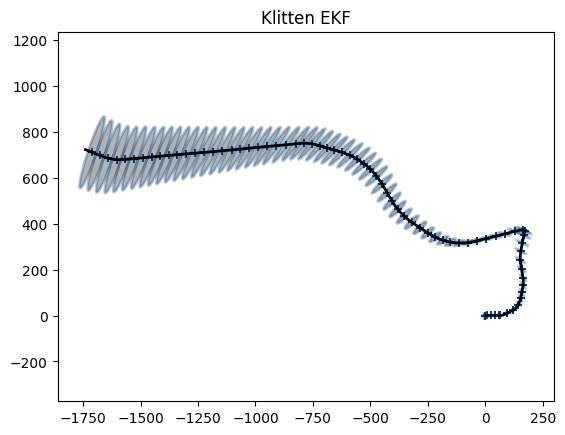

In [63]:
run_CTRV_EKF(sim_duration = 400, dt_step = 0.5, dt_track = 0.05)

### Testcode

# 4. Design Measurement Noise

# 5. Implementation

If the curve above is the process model, then the dotted lines shows the linearization of that curve for the estimate $x=1.5$.

We linearize systems by taking the derivative, which finds the slope of a curve:

$$\begin{aligned}
f(x) &= x^2 -2x \\
\frac{df}{dx} &= 2x - 2
\end{aligned}$$

and then evaluating it at $x$:

$$\begin{aligned}m &= f'(x=1.5) \\&= 2(1.5) - 2 \\&= 1\end{aligned}$$ 

Linearizing systems of differential equations is similar. We linearize $f(\mathbf x, \mathbf u)$, and $h(\mathbf x)$ by taking the partial derivatives of each to evaluate $\mathbf F$ and $\mathbf H$ at the point $\mathbf x_t$ and $\mathbf u_t$. We call the partial derivative of a matrix the [*Jacobian*](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant). This gives us the the discrete state transition matrix and measurement model matrix:

$$
\begin{aligned}
\mathbf F 
&= {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}} \\
\mathbf H &= \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t} 
\end{aligned}
$$

This leads to the following equations for the EKF. I put boxes around the differences from the linear filter:

$$\begin{array}{l|l}
\text{linear Kalman filter} & \text{EKF} \\
\hline 
& \boxed{\mathbf F = {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}}} \\
\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu} & \boxed{\mathbf{\bar x} = f(\mathbf x, \mathbf u)}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q  & \mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q \\
\hline
& \boxed{\mathbf H = \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}} \\
\textbf{y} = \mathbf z - \mathbf{H \bar{x}} & \textbf{y} = \mathbf z - \boxed{h(\bar{x})}\\
\mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} & \mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
\mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} & \mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} \\
\mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} & \mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}}
\end{array}$$

We don't normally use $\mathbf{Fx}$ to propagate the state for the EKF as the linearization causes inaccuracies. It is typical to compute $\bar{\mathbf x}$ using a suitable numerical integration technique such as Euler or Runge Kutta. Thus I wrote $\mathbf{\bar x} = f(\mathbf x, \mathbf u)$. For the same reasons we don't use $\mathbf{H\bar{x}}$ in the computation for the residual, opting for the more accurate $h(\bar{\mathbf x})$.

I think the easiest way to understand the EKF is to start off with an example. Later you may want to come back and reread this section.